# Finite Element Methods for Isometric Materials

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" 
from firedrake import *
from firedrake.pyplot import triplot
import matplotlib.pyplot as plt

## Compressive buckling:
Let $\Omega=(-2, 2)\times (0, 1)$ and $\partial_D \Omega = \{-2, 2\}\times [0, 1]$ be two sides where we impose the compressive boundary conditions $g=(x_1\pm 1.4, x_2, 0)$ and $\Phi=[I_2, 0]^T$. We apply a vertical force $f=(0, 0, 10^{-2})$.

### Discrete Galerkin approach

1. The space of discontinuous functions over the mesh:
    $$\mathbb{V}_h^k := \{v_h \in \mathcal{L}^2(\Omega): v_h \circ F_T \in \mathbb{P}_k \quad \forall T\in \mathcal{T}_h \}$$

2. The jumps:
    $$
    \begin{cases}
    [v_h]_e := v_h^- - v_h^+ , \quad [\nabla_h v_h]_e:= \nabla_h v_h^- - \nabla_h v_h^+, \quad \forall e\in \mathcal{E}_h^0\\
    [v_h]_e := v_h - g, \quad [\nabla_h v_h]_e:= \nabla_h v_h - \Phi, \quad \forall e\in \mathcal{E}_h^b
    \end{cases}
    $$

3. The averages:
    $$
    \begin{cases}
    {v_h} := (v_h^- + v_h^+)/2 , \quad {\nabla_h v_h}:= (\nabla_h v_h^- + \nabla_h v_h^+)/2, \quad \forall e\in \mathcal{E}_h^0\\
    {v_h} := v_h^-, \quad {\nabla_h v_h}:= \nabla_h v_h^-, \quad \forall e\in \mathcal{E}_h^b
    \end{cases}
    $$

4. The bilinear form:
    $$
    \begin{align*}
    a_h(y, v_h)&:= (D^2y, D^2_h v_h)_{\mathcal{L}^2(\Omega)} \\
    & - (\{\partial_\mu \nabla y\}, [\nabla v_h])_{\mathcal{L}^2(\Gamma_h)} - (\{\partial_\mu \nabla_h v_h\}, [\nabla y])_{\mathcal{L}^2(\Gamma_h)}\\
    & + (\{\partial_\mu \Delta y \}, [v_h])_{\mathcal{L}^2(\Gamma_h)} + (\{\partial_\mu \Delta_h v_h\}, [y])_{\mathcal{L}^2(\Gamma_h)}\\
    & + \gamma_1 (h^{-1}[\nabla y], [\nabla_h v_h])_{\mathcal{L}^2(\Gamma_h)} + \gamma_0 (h^{-3/2}[y], [v_h])_{\mathcal{L}^2(\Gamma_h)} 
    \end{align*}
$$

5. The discrete H^2-scalar product:
    $$
    \begin{align*}
    (w_h, v_h)_{H^2_h(\Omega)} &:= (D^2_h w_h, D^2_h v_h)_{\mathcal{L}^2(\Omega)} \\
    & + (h^{-1}[\nabla_h w_h], [\nabla_h v_h])_{\mathcal{L}^2(\Gamma_h)} + (h^{-3}[w_h], [v_h])_{\mathcal{L}^2(\Gamma_h)} 
    \end{align*}
    $$

<!-- 6. The discrete linearized isometry constraint:
    $$
    L_T[y_h; v_h]:= \int_T (\nabla_h v_h)^T \nabla_h y_h + (\nabla_h y_h)^T \nabla_h v_h = 0 \quad \forall v_h \in \mathbb{V}_h^k(0, 0)
    $$

7. The tangent manifold to the discrete linearized isometry constraint at $y_h$:
    $$
    \mathcal{F}_h[y_h]:=\{ v_h \in \mathbb{V}_h^k(0, 0): L_T[y_h; v_h]=0 \quad \forall T \in \mathcal{T}_h\}
    $$ -->

6. Saddle point formulation:
    
    Consider the bilinear form $l_h(y_h; \cdot, \cdot):[\mathbb{V}_h^k]^3 \times [\mathbb{V}_h^0]^{2\times2}$ given by:
    $$
    l_h(y_h; v_h, \mu_h):=\sum_{T \in \mathcal{T}_h} \int_T \mu :\left( (\nabla_h v_h)^T \nabla_h y_h + (\nabla_h y_h)^T \nabla_h v_h \right)
    $$

    Find $(\delta y_h^{n+1}, \lambda^{n+1}_h) \in [\mathbb{V}_h^k]^3 \times [\mathbb{V}_h^0]^{2\times2}$ such that for all $(v_h, \mu_h)\in [\mathbb{V}_h^k]^3 \times [\mathbb{V}_h^0]^{2\times2}$ there holds
    $$
    \begin{align*}
    \tau^{-1} (\delta y^{n+1}_h, v_h)_{H^2_h(\Omega)} + a_h(\delta y^{n+1}, v_h) + l_h(y_h^n;v_h, \lambda_h^{n+1}) &= -a_h(y_h^n, v_h)+(f, v_h)_{\mathcal{L}^2(\Omega)}\\
    l_h(y_h^n;\delta y_h^{n+1}, \mu_h) &=0
    \end{align*}
    $$


In [2]:
Lx, Ly = 4.0, 1.0
nx, ny = 40, 10
mesh = RectangleMesh(nx, ny, Lx, Ly)
mesh.coordinates.dat.data[:, 0] -= 2

V = VectorFunctionSpace(mesh, 'DG', degree=2, dim=3)
W = TensorFunctionSpace(mesh, 'DG', degree=0, shape=(2, 2))
GV = TensorFunctionSpace(mesh, 'DG', degree=2, shape=(3, 2))

x = SpatialCoordinate(mesh)

g = Function(V).interpolate(as_vector([
    conditional(lt(x[0], 0), x[0] - 1.4, x[0] + 1.4), x[1], 0]))
Phi = Function(GV).interpolate(as_matrix([[1, 0], [0, 1], [0, 0]]))
f = Function(V).interpolate(as_vector([0, 0, 1e-2]))

n = FacetNormal(mesh)
h = CellSize(mesh)
h_avg = (h('+')+h('-'))/2

def a_h(y, v, g=g, Phi=Phi, r0=1e4, r1=1e4):
    return inner(grad(grad(y)), grad(grad(v)))*dx -\
            inner(avg(n[i] * grad(grad(y))[:, :, i]),  -jump(grad(v)))*dS -\
            inner(avg(n[i] * grad(grad(v))[:, :, i]),  -jump(grad(y)))*dS -\
            inner((n[i] * grad(grad(y))[:, :, i])('-'), grad(v)-Phi)*ds -\
            inner((n[i] * grad(grad(v))[:, :, i])('-'), grad(y)-Phi)*ds +\
            inner(avg(n[i] * div(grad(grad(y)))[:, i]), -jump(v))*dS +\
            inner((n[i] * div(grad(grad(v)))[:, i])('-'), -jump(y))*dS +\
            inner((n[i] * div(grad(grad(y)))[:, i])('-'), v-g)*ds +\
            inner((n[i] * div(grad(grad(v)))[:, i])('-'), y-g)*ds +\
            r1*inner(-h_avg**(-1)*jump(grad(y)), -jump(grad(v)))*dS +\
            r1*inner(h_avg**(-1)*(grad(y)-Phi), grad(v)-Phi)*ds +\
            r0*inner(-h_avg**(-3/2)*jump(y), -jump(v))*dS +\
            r0*inner(h_avg**(-3/2)*(y-g), v-g)*ds

def H_h(y, v, g=g, Phi=Phi):
    return inner(grad(grad(y)), grad(grad(v)))*dx -\
            inner(-h_avg**(-1)*jump(grad(y)), -jump(grad(v)))*dS +\
            inner(h_avg**(-1)*(grad(y)-Phi), grad(v)-Phi)*ds +\
            inner(-h_avg**(-3)*jump(y), -jump(v))*dS +\
            inner(h_avg**(-3) * (y-g), v-g)*ds

def l_h(y, v, mu):
    return inner(mu, grad(v).T*grad(y) + grad(y).T*grad(v)) * dx

In [3]:
# y0 = Function(V).interpolate(as_vector([0, 0, 0]))

# y_h = y0
# tau = 0.04625
# n_iters = 1

# Z = MixedFunctionSpace([V, W])
# z = Function(Z)
# delta_y_h, lambda_h = z.subfunctions

# v_h, mu_h = TestFunctions(Z)

# for iter in range(n_iters):
#     F1 = (1/tau)*H_h(delta_y_h, v_h) #+ a_h(delta_y_h, v_h)  + l_h(y_h, v_h, lambda_h) + a_h(y_h, v_h) - dot(f, v_h)*dx
#     F2 = l_h(y_h, delta_y_h, mu_h)
#     F = F1 + F2
#     problem = NonlinearVariationalProblem(F1, delta_y_h)
#     solver = NonlinearVariationalSolver(problem)

### 'FAKE' isometric constraint approach

In [4]:
Lx, Ly = 4.0, 1.0
nx, ny = 80, 20
mesh = RectangleMesh(nx, ny, Lx, Ly)
mesh.coordinates.dat.data[:, 0] -= 2

V = VectorFunctionSpace(mesh, 'CG', degree=2, dim=3)
W = TensorFunctionSpace(mesh, 'CG', degree=2, shape=(2, 2))
GV = TensorFunctionSpace(mesh, 'CG', degree=2, shape=(3, 2))

x = SpatialCoordinate(mesh)

g = Function(V).interpolate(as_vector([
    conditional(lt(x[0], 0), x[0] - 1.4, x[0] + 1.4), x[1], 0]))
Phi = Function(GV).interpolate(as_matrix([[1, 0], [0, 1], [0, 0]]))
f = Function(V).interpolate(as_vector([0, 0, 1e-2]))

In [5]:
y = Function(V)
vh = TestFunction(V)

F = inner(grad(grad(y)), grad(grad(vh)))*dx - dot(f, vh)*dx + inner(y-g, vh)*ds + inner(grad(y) - Phi, grad(vh))*ds
F += 2*inner(grad(y), grad(vh)) * dx # NOT TRUE!

problem = NonlinearVariationalProblem(F, y)
solver = NonlinearVariationalSolver(problem)
solver.solve()

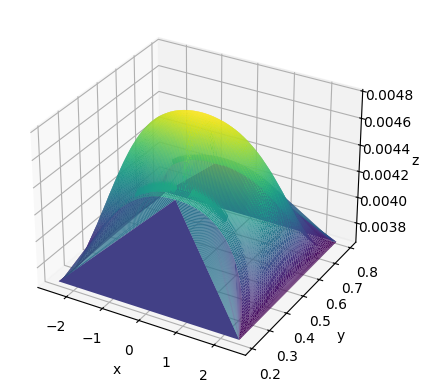

In [6]:
# fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
# ts = trisurf(y, axes=ax)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(y.dat.data[:,0], y.dat.data[:,1], y.dat.data[:,2], cmap='viridis', facecolors=plt.cm.viridis(y.dat.data[:,1]))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Mixed finite element method approach

In [7]:
Lx, Ly = 4.0, 1.0
nx, ny = 80, 20
mesh = RectangleMesh(nx, ny, Lx, Ly)
mesh.coordinates.dat.data[:, 0] -= 2

V = VectorFunctionSpace(mesh, 'CG', degree=2, dim=3)
W = TensorFunctionSpace(mesh, 'CG', degree=1, shape=(2, 2))
GV = TensorFunctionSpace(mesh, 'CG', degree=2, shape=(3, 2))

x = SpatialCoordinate(mesh)

g = Function(V).interpolate(as_vector([x[0], x[1], 0]))

g_expr1 = as_vector([x[0], x[1], 0])
g1 = Function(V).interpolate(g_expr1)

g_expr2 = as_vector([x[0], x[1], 0])
g2 = Function(V).interpolate(g_expr2)

Phi = Function(GV).interpolate(as_matrix([[0, 0], [0, 0], [0, 0]]))
f = Function(V).interpolate(as_vector([0, 0, 0]))

In [8]:
Z = V*W
vh, wh = TestFunctions(Z)
z = Function(Z)
y, mu = split(z)

In [9]:
F = inner(grad(grad(y)), grad(grad(vh)))*dx - dot(f, vh)*dx +inner(y-g, vh)*ds + inner(grad(y)-Phi, grad(vh))*ds
F += inner(mu, grad(vh).T*grad(y) + grad(y).T*grad(vh)) * dx + inner(wh, mu)*dx

problem = NonlinearVariationalProblem(F, z)
solver = NonlinearVariationalSolver(problem)
solver.solve()

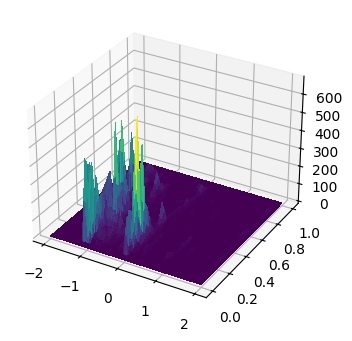

In [10]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(z.sub(0).dat.data[:, 0], z.sub(0).dat.data[:, 1], z.sub(0).dat.data[:, 2], cmap='viridis', facecolors=plt.cm.viridis(z.sub(0).dat.data[:,1]))

# ax.set_xlabel('y1')
# ax.set_ylabel('y2')
# ax.set_zlabel('y3')

# plt.show()

fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(z.sub(0), axes=ax)


## Beam bending:

In [11]:
mesh = IntervalMesh(10, 0, 4)

V = VectorFunctionSpace(mesh, "CG", 2, dim=2)
GV = TensorFunctionSpace(mesh, 'CG', 2, shape=(2, 1))

x = SpatialCoordinate(mesh)

g_expr1 = as_vector([x[0], 0])
g1 = Function(V).interpolate(g_expr1)

g_expr2 = as_vector([x[0], 0])
g2 = Function(V).interpolate(g_expr2)

Phi_expr1 = as_tensor([[0], [0]])
Phi1 = Function(GV).interpolate(Phi_expr1)

Phi_expr2 = as_tensor([[0], [0]])
Phi2 = Function(GV).interpolate(Phi_expr2)

Phi_expr = as_tensor([[0], [0]])
Phi = Function(GV).interpolate(Phi_expr)

f_expr =  as_vector([0, -2.5e-2])
f = Function(V).interpolate(f_expr)

y = Function(V)
vh = TestFunction(V)

In [12]:
# F = inner(grad(grad(y)), grad(grad(vh)))*dx - dot(f, vh)*dx
F = inner(grad(grad(y)), grad(grad(vh)))*dx - dot(f, vh)*dx +inner(y-g1, vh)*ds(1) + inner(y-g2, vh)*ds(2) + inner(grad(y)-Phi1, grad(vh))*ds(1) + inner(grad(y)-Phi2, grad(vh))*ds(2)
F += 2*inner(grad(y), grad(vh)) * dx
problem = NonlinearVariationalProblem(F, y)
solver = NonlinearVariationalSolver(problem)
solver.solve()

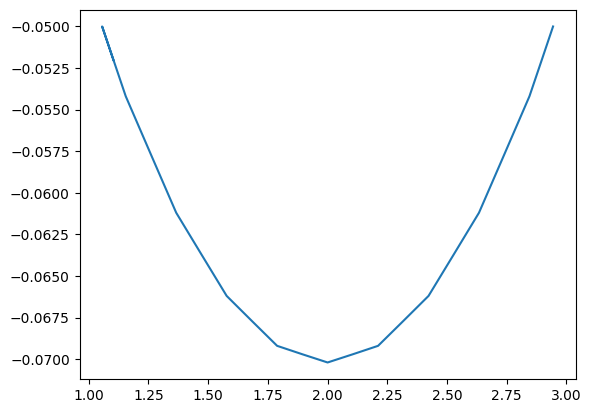

In [13]:
plt.plot(y.dat.data[:,0], y.dat.data[:,1])
plt.show()

### Mixed finite element approach

In [14]:
mesh = IntervalMesh(10, 0, 5)

V = VectorFunctionSpace(mesh, "DG", 2, dim=2)
GV = TensorFunctionSpace(mesh, 'DG', 2, shape=(2, 1))
W = TensorFunctionSpace(mesh, 'DG', 1, shape=(1, 1))

x = SpatialCoordinate(mesh)

g_expr1 = as_vector([0, 0])
g1 = Function(V).interpolate(g_expr1)

g_expr2 = as_vector([5, 0])
g2 = Function(V).interpolate(g_expr2)

Phi_expr1 = as_tensor([[0], [0]])
Phi1 = Function(GV).interpolate(Phi_expr1)

Phi_expr2 = as_tensor([[0], [0]])
Phi2 = Function(GV).interpolate(Phi_expr2)

f_expr =  as_vector([0, 0])
f = Function(V).interpolate(f_expr)

In [15]:
Z = V*W
vh, wh = TestFunctions(Z)
z = Function(Z)
y, mu = split(z)

In [16]:
F = inner(grad(grad(y)), grad(grad(vh)))*dx - dot(f, vh)*dx +inner(y-g1, vh)*ds(1) + inner(y-g2, vh)*ds(2) + inner(grad(y)-Phi1, grad(vh))*ds(1) + inner(grad(y)-Phi2, grad(vh))*ds(2)
F += inner(mu, grad(vh).T*grad(y) + grad(y).T*grad(vh)) * dx + inner(wh, mu)*dx

In [17]:
problem = NonlinearVariationalProblem(F, z)
solver = NonlinearVariationalSolver(problem)
solver.solve()

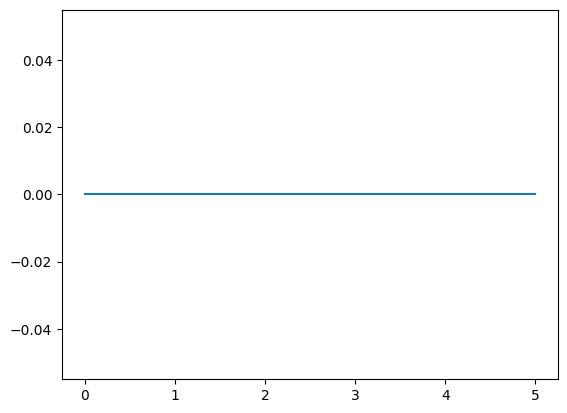

In [18]:
plt.plot(z.sub(0).dat.data[:,0], z.sub(0).dat.data[:,1])
plt.show()

## Test place

In [19]:
import numpy as np
from scipy.linalg import expm
from scipy.linalg import logm
A = np.random.rand(3, 3)

A = A - A.T
Q = expm(A)
print(Q.T@Q)

[[ 1.00000000e+00 -1.71945072e-16  2.83940399e-17]
 [-1.71945072e-16  1.00000000e+00 -7.74781056e-18]
 [ 2.83940399e-17 -7.74781056e-18  1.00000000e+00]]


In [20]:
A = np.random.rand(3, 3)
Q, R = np.linalg.qr(A)
logm(Q)

array([[-4.68739528e-16,  1.38058977e+00,  7.64770269e-01],
       [-1.38058977e+00, -5.08197547e-16, -1.54486468e-01],
       [-7.64770269e-01,  1.54486468e-01, -2.15234520e-16]])

In [21]:
import finat
print(finat.ufl.mixedelement.TensorElement)

<class 'finat.ufl.mixedelement.TensorElement'>
